In [1]:
#0: imports

import uproot 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from dataAnalyse import CCV1
from torch_geometric.data import DataLoader 
from models import Net_SEC
from torch_geometric.nn import knn_graph

import numpy as np
import time

import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
#1: Load Data + Model
#1.1: Load Data Through the dataloader - used for predictions
testpath = "/vols/cms/mm1221/Data/100k/5pi/test/"  
data_test = CCV1(testpath, max_events=15000, inp = 'test')
test_loader = DataLoader(data_test, batch_size=1, shuffle=False, follow_batch=['x'])


### Loading tracksters data


  0%|                                                     | 0/1 [00:00<?, ?it/s]

/vols/cms/mm1221/Data/100k/5pi/test/raw/test.root


100%|█████████████████████████████████████████████| 1/1 [00:14<00:00, 14.80s/it]
/cvmfs/sft.cern.ch/lcg/views/LCG_105a_cuda/x86_64-el9-gcc11-opt/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [3]:
# load the model 
#model = Net(
    #hidden_dim=128,
    #num_layers=4,
    #dropout=0.3,
    #contrastive_dim=16
#)
model = Net_SEC(
    hidden_dim=256,
    num_layers=3,
    dropout=0.3,
    contrastive_dim=512
)

checkpoint= torch.load('/vols/cms/mm1221/hgcal/Mixed/Track/NegativeMining/runs/SECNEW/hd256nl3cd512k64/epoch-99.pt',  map_location=torch.device('cpu'))
#checkpoint= torch.load('/vols/cms/mm1221/hgcal/elec5New/Track/NegativeMining/resultsSECNeg/epoch-228.pt',  map_location=torch.device('cpu'))

model.load_state_dict(checkpoint['model'])  
model.eval()  

Net_SEC(
  (lc_encode): Sequential(
    (0): Linear(in_features=16, out_features=256, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): ELU(alpha=1.0)
  )
  (convs): ModuleList(
    (0-2): 3 x CustomStaticEdgeConv(
      (nn_module): Sequential(
        (0): Linear(in_features=512, out_features=256, bias=True)
        (1): ELU(alpha=1.0)
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Dropout(p=0.3, inplace=False)
      )
    )
  )
  (output): Sequential(
    (0): Linear(in_features=256, out_features=64, bias=True)
    (1): ELU(alpha=1.0)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ELU(alpha=1.0)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=32, out_features=512, bias=True)
  )
)

In [4]:

#3: Make Predictions + Cluster -> Calculate the inference time
#3.1: Make Predictions



all_predictions = []  
total_times = []
start_time = time.time()

for i, data in enumerate(data_test):
    
    if i>500:
        break
    print(i)

        
    
    edge_index = knn_graph(data.x, k=64)  
    predictions = model(data.x, edge_index, 1)
    all_predictions.append(predictions[0].detach().cpu().numpy())  

all_predictions = np.array(all_predictions)




end_time = time.time()

#3.3: Calculate average inference time

time_diff = end_time - start_time


#all_cluster_labels = affinity_propagation_clustering(all_predictions, damping=0.65)



0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

Processing events: 100%|██████████████████████| 500/500 [00:06<00:00, 79.77it/s]


Mean Positive Edge Cosine Similarity: 0.9125
Mean Negative Edge Cosine Similarity: 0.3485


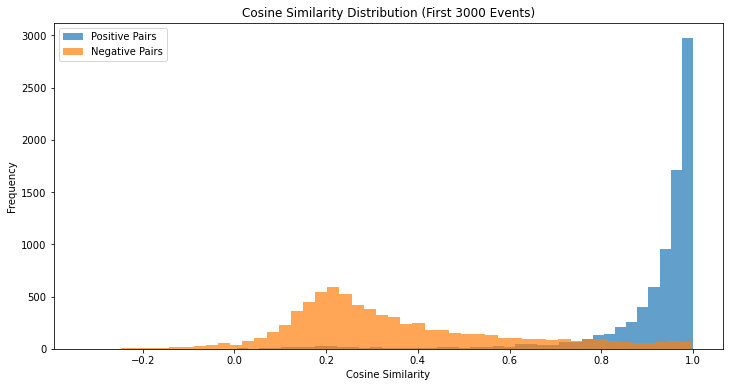

In [5]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute cosine similarities from a set of edge indices.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    Given embeddings (tensor of shape [N, D]) and edge_indices (tensor of shape [num_edges, 2]),
    compute the cosine similarity for each edge.
    If skip_self is True, edges where source==target are skipped.
    Returns a NumPy array of similarities.
    """
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        # Cosine similarity for unit-norm embeddings is just their dot product.
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0), embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Assuming:
# - all_predictions is a list (length >= 1000) of NumPy arrays,
#   where each element is an array of embeddings for one event.
# - data_test is a list (length >= 1000) of data objects with attributes x_pe and x_ne
#   (each as tensors of shape [num_nodes, 2]) that give the positive and negative edge indices.
# If you do not already have normalized embeddings in all_predictions, we will normalize them.

num_events = 500
all_pos_sims = []
all_neg_sims = []

# Loop over the first 1000 events.
for i in tqdm(range(num_events), desc="Processing events"):
    # Convert predictions for event i to a tensor and normalize them.
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
    pred_norm = F.normalize(pred_tensor, p=2, dim=1)

    # Compute cosine similarities for positive and negative edges.
    pos_sims = compute_cosine_similarities(pred_norm, data_test[i].x_pe, skip_self=True)
    neg_sims = compute_cosine_similarities(pred_norm, data_test[i].x_ne, skip_self=True)
    
    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims = np.array(all_pos_sims)
all_neg_sims = np.array(all_neg_sims)


 
mean_pos_sim = np.mean(all_pos_sims)
mean_neg_sim = np.mean(all_neg_sims)

print(f"Mean Positive Edge Cosine Similarity: {mean_pos_sim:.4f}")
print(f"Mean Negative Edge Cosine Similarity: {mean_neg_sim:.4f}")

# Plot histograms for positive and negative cosine similarities.
plt.figure(figsize=(12, 6))
plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs")
plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution (First 3000 Events)")
plt.legend()
plt.show()


Processing events: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:06<00:00, 81.95it/s]


Mean Positive Edge Cosine Similarity: 0.9204
Mean Negative Edge Cosine Similarity: 0.3636


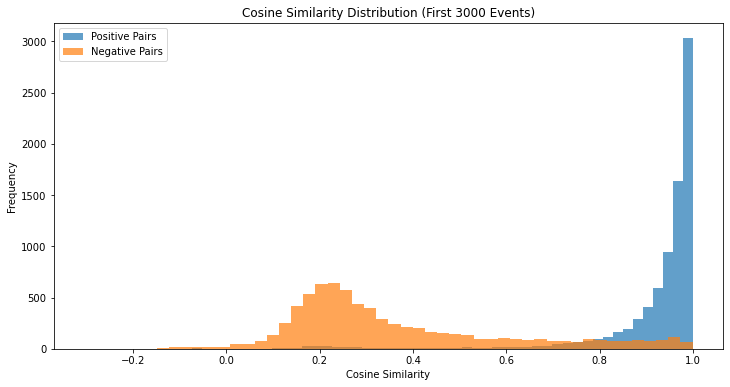

In [22]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm

# Function to compute cosine similarities from a set of edge indices.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    """
    Given embeddings (tensor of shape [N, D]) and edge_indices (tensor of shape [num_edges, 2]),
    compute the cosine similarity for each edge.
    If skip_self is True, edges where source==target are skipped.
    Returns a NumPy array of similarities.
    """
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        # Cosine similarity for unit-norm embeddings is just their dot product.
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0), embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Assuming:
# - all_predictions is a list (length >= 1000) of NumPy arrays,
#   where each element is an array of embeddings for one event.
# - data_test is a list (length >= 1000) of data objects with attributes x_pe and x_ne
#   (each as tensors of shape [num_nodes, 2]) that give the positive and negative edge indices.
# If you do not already have normalized embeddings in all_predictions, we will normalize them.

num_events = 500
all_pos_sims = []
all_neg_sims = []

# Loop over the first 1000 events.
for i in tqdm(range(num_events), desc="Processing events"):
    # Convert predictions for event i to a tensor and normalize them.
    pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
    pred_norm = F.normalize(pred_tensor, p=2, dim=1)

    # Compute cosine similarities for positive and negative edges.
    pos_sims = compute_cosine_similarities(pred_norm, data_test[i].x_pe, skip_self=True)
    neg_sims = compute_cosine_similarities(pred_norm, data_test[i].x_ne, skip_self=True)
    
    all_pos_sims.extend(pos_sims.tolist())
    all_neg_sims.extend(neg_sims.tolist())

all_pos_sims = np.array(all_pos_sims)
all_neg_sims = np.array(all_neg_sims)


 
mean_pos_sim = np.mean(all_pos_sims)
mean_neg_sim = np.mean(all_neg_sims)

print(f"Mean Positive Edge Cosine Similarity: {mean_pos_sim:.4f}")
print(f"Mean Negative Edge Cosine Similarity: {mean_neg_sim:.4f}")

# Plot histograms for positive and negative cosine similarities.
plt.figure(figsize=(12, 6))
plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs")
plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.title("Cosine Similarity Distribution (First 3000 Events)")
plt.legend()
plt.show()


In [7]:
import os
import time
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch_geometric.nn import knn_graph

# Function to compute cosine similarities for a set of edge indices.
def compute_cosine_similarities(embeddings, edge_indices, skip_self=True):
    sims = []
    for edge in edge_indices:
        src, tgt = edge.tolist()
        if skip_self and src == tgt:
            continue
        sim = F.cosine_similarity(embeddings[src].unsqueeze(0),
                                  embeddings[tgt].unsqueeze(0))
        sims.append(sim.item())
    return np.array(sims)

# Create the output directory if it does not exist.
gif_dir = "Gif"
os.makedirs(gif_dir, exist_ok=True)

# Instantiate your model once.
model = Net_SEC(hidden_dim=256, num_layers=3, dropout=0.3, contrastive_dim=512)

# Number of events to process per epoch.
num_events = 100

# Loop over epochs: every other epoch from 1 to 73.
for epoch in range(1, 30,1):
    print(f"Processing epoch {epoch}...")
    
    # Construct the checkpoint path (adjust if needed).
    checkpoint_path = f'/vols/cms/mm1221/hgcal/Mixed/Track/NegativeMining/runs/SECNEW/hd256nl3cd512k64/epoch-{epoch}.pt'
    
    # Load the checkpoint and update the model.
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model'])
    model.eval()
    
    all_predictions = []
    start_time = time.time()
    
    # Run predictions on the test data.
    for i, data in enumerate(data_test):
        if i >= num_events:
            break
        edge_index = knn_graph(data.x, k=16)
        predictions = model(data.x, edge_index, 1)
        all_predictions.append(predictions[0].detach().cpu().numpy())
    
    all_predictions = np.array(all_predictions)
    end_time = time.time()
    print(f"Inference time for epoch {epoch}: {end_time - start_time:.2f} s")
    
    # Compute cosine similarities.
    all_pos_sims = []
    all_neg_sims = []
    
    for i in tqdm(range(num_events), desc=f"Epoch {epoch} cosine sims"):
        pred_tensor = torch.tensor(all_predictions[i], dtype=torch.float32)
        pred_norm = F.normalize(pred_tensor, p=2, dim=1)
        
        pos_sims = compute_cosine_similarities(pred_norm, data_test[i].x_pe, skip_self=True)
        neg_sims = compute_cosine_similarities(pred_norm, data_test[i].x_ne, skip_self=True)
        
        all_pos_sims.extend(pos_sims.tolist())
        all_neg_sims.extend(neg_sims.tolist())
    
    all_pos_sims = np.array(all_pos_sims)
    all_neg_sims = np.array(all_neg_sims)
    
    mean_pos_sim = np.mean(all_pos_sims)
    mean_neg_sim = np.mean(all_neg_sims)
    
    # Plot the histograms.
    plt.figure(figsize=(12, 6))
    # Positive pairs in orange.
    plt.hist(all_pos_sims, bins=50, alpha=0.7, label="Positive Pairs", color='tab:orange')
    # Negative pairs in blue.
    plt.hist(all_neg_sims, bins=50, alpha=0.7, label="Negative Pairs", color='tab:blue')
    
    # Fix the x-axis from -1 to 1.
    plt.xlim([-1, 1])
    # Fix the y-axis to a constant range (adjust the upper limit as needed).
    plt.ylim(0, 250)
    
    # Remove y-axis label and ticks.
    plt.ylabel("")
    plt.yticks([])
    plt.legend(loc='upper right')
    
    # Save the plot to the Gif folder.
    save_path = os.path.join(gif_dir, f"epoch_{epoch}.png")
    plt.savefig(save_path)
    plt.close()
    print(f"Saved plot for epoch {epoch} to {save_path}")


Processing epoch 1...
Inference time for epoch 1: 19.86 s


Epoch 1 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 66.37it/s]


Saved plot for epoch 1 to Gif/epoch_1.png
Processing epoch 2...
Inference time for epoch 2: 14.57 s


Epoch 2 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 58.74it/s]


Saved plot for epoch 2 to Gif/epoch_2.png
Processing epoch 3...
Inference time for epoch 3: 1.12 s


Epoch 3 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 69.67it/s]


Saved plot for epoch 3 to Gif/epoch_3.png
Processing epoch 4...
Inference time for epoch 4: 1.12 s


Epoch 4 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 70.00it/s]


Saved plot for epoch 4 to Gif/epoch_4.png
Processing epoch 5...
Inference time for epoch 5: 1.10 s


Epoch 5 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 69.82it/s]


Saved plot for epoch 5 to Gif/epoch_5.png
Processing epoch 6...
Inference time for epoch 6: 1.10 s


Epoch 6 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 70.12it/s]


Saved plot for epoch 6 to Gif/epoch_6.png
Processing epoch 7...
Inference time for epoch 7: 1.10 s


Epoch 7 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 69.49it/s]


Saved plot for epoch 7 to Gif/epoch_7.png
Processing epoch 8...
Inference time for epoch 8: 1.10 s


Epoch 8 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 67.03it/s]


Saved plot for epoch 8 to Gif/epoch_8.png
Processing epoch 9...
Inference time for epoch 9: 1.11 s


Epoch 9 cosine sims: 100%|████████████████████| 100/100 [00:01<00:00, 67.87it/s]


Saved plot for epoch 9 to Gif/epoch_9.png
Processing epoch 10...
Inference time for epoch 10: 1.09 s


Epoch 10 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 68.92it/s]


Saved plot for epoch 10 to Gif/epoch_10.png
Processing epoch 11...
Inference time for epoch 11: 1.16 s


Epoch 11 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 68.97it/s]


Saved plot for epoch 11 to Gif/epoch_11.png
Processing epoch 12...
Inference time for epoch 12: 1.14 s


Epoch 12 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 73.97it/s]


Saved plot for epoch 12 to Gif/epoch_12.png
Processing epoch 13...
Inference time for epoch 13: 1.09 s


Epoch 13 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 74.17it/s]


Saved plot for epoch 13 to Gif/epoch_13.png
Processing epoch 14...
Inference time for epoch 14: 1.08 s


Epoch 14 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 74.77it/s]


Saved plot for epoch 14 to Gif/epoch_14.png
Processing epoch 15...
Inference time for epoch 15: 1.13 s


Epoch 15 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.84it/s]


Saved plot for epoch 15 to Gif/epoch_15.png
Processing epoch 16...
Inference time for epoch 16: 1.11 s


Epoch 16 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.61it/s]


Saved plot for epoch 16 to Gif/epoch_16.png
Processing epoch 17...
Inference time for epoch 17: 1.08 s


Epoch 17 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.41it/s]


Saved plot for epoch 17 to Gif/epoch_17.png
Processing epoch 18...
Inference time for epoch 18: 1.01 s


Epoch 18 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.72it/s]


Saved plot for epoch 18 to Gif/epoch_18.png
Processing epoch 19...
Inference time for epoch 19: 1.02 s


Epoch 19 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 76.90it/s]


Saved plot for epoch 19 to Gif/epoch_19.png
Processing epoch 20...
Inference time for epoch 20: 1.11 s


Epoch 20 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.39it/s]


Saved plot for epoch 20 to Gif/epoch_20.png
Processing epoch 21...
Inference time for epoch 21: 1.11 s


Epoch 21 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.51it/s]


Saved plot for epoch 21 to Gif/epoch_21.png
Processing epoch 22...
Inference time for epoch 22: 1.12 s


Epoch 22 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.73it/s]


Saved plot for epoch 22 to Gif/epoch_22.png
Processing epoch 23...
Inference time for epoch 23: 1.12 s


Epoch 23 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 77.83it/s]


Saved plot for epoch 23 to Gif/epoch_23.png
Processing epoch 24...
Inference time for epoch 24: 1.06 s


Epoch 24 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 78.03it/s]


Saved plot for epoch 24 to Gif/epoch_24.png
Processing epoch 25...
Inference time for epoch 25: 1.12 s


Epoch 25 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 70.80it/s]


Saved plot for epoch 25 to Gif/epoch_25.png
Processing epoch 26...
Inference time for epoch 26: 1.04 s


Epoch 26 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 70.11it/s]


Saved plot for epoch 26 to Gif/epoch_26.png
Processing epoch 27...
Inference time for epoch 27: 1.04 s


Epoch 27 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 72.57it/s]


Saved plot for epoch 27 to Gif/epoch_27.png
Processing epoch 28...
Inference time for epoch 28: 1.04 s


Epoch 28 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 72.00it/s]


Saved plot for epoch 28 to Gif/epoch_28.png
Processing epoch 29...
Inference time for epoch 29: 1.03 s


Epoch 29 cosine sims: 100%|███████████████████| 100/100 [00:01<00:00, 72.73it/s]


Saved plot for epoch 29 to Gif/epoch_29.png


In [8]:
import imageio
import os

# Folder where your PNG files are stored.
folder = 'Gif'
# Get list of PNG files sorted in order.
filenames = sorted([os.path.join(folder, f) for f in os.listdir(folder) if f.endswith('.png')])

# Read images into a list.
images = [imageio.imread(filename) for filename in filenames]

# Save the images as a GIF.
gif_path = 'animation.gif'
# 'duration' is the time between frames in seconds.
imageio.mimsave(gif_path, images, duration=0.5)

print(f"GIF saved as {gif_path}")


/tmp/ipykernel_1736482/2554933103.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(filename) for filename in filenames]


GIF saved as animation.gif
